# Самостоятельный проект - Выбор локации для скважины

В данном исследовании мы определеим наиболее выгодный регион нефтедобычи исходя из данных предоставленных добывающей компанией «ГлавРосГосНефть». 

**Цели:** 

 - На основе предоставленных данных построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль с наименьшими рисками.

**Ход исследования:**

- Загрузим и подготовим данные.
- Обучим предсказательную модель на подготовленных данных.
- Произведем подготовку к расчету прибыли и рисков.
- Рассчитаем среднюю прибыль, 95% доверительный интервал прибыли и риски по каждому из регионов.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
    
`/datasets/geo_data_0.csv `

`/datasets/geo_data_1.csv `

`/datasets/geo_data_2.csv `

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).
    

# Условия задачи
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
    
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
    
Бюджет на разработку скважин в регионе — 10 млрд рублей.
    
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
    
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

# Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Загрузка и обзор данных

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
# вывод первых строк и общей информации о датасете
geo_data_0.info()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
#Вывод описательной статистики 
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


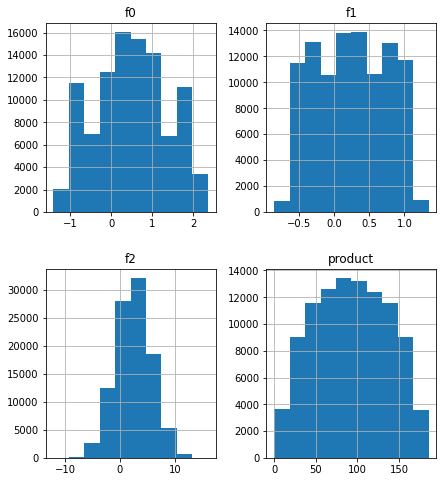

In [5]:
#Построение гистограммы для числовых значений
geo_data_0.hist(figsize=(7,8))
plt.show()

**Датасет `geo_data_0`**  медианный объем запасов составляет около 92 тыс. барраллей

In [6]:
# вывод первых строк и общей информации о датасете
geo_data_1.info()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
#Вывод описательной статистики 
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


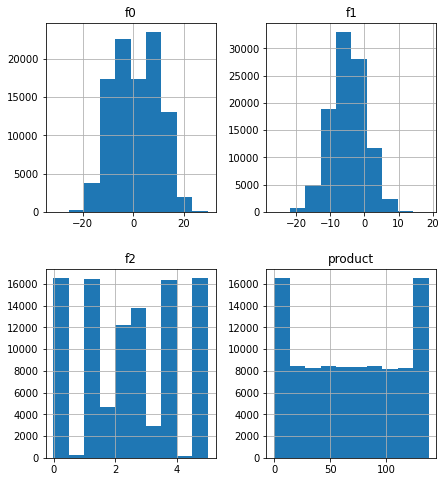

In [8]:
#Построение гистограммы для числовых значений
geo_data_1.hist(figsize=(7,8))
plt.show()

**Датасет `geo_data_1`**  медианный объем запасов составляет около 57 тыс. барраллей

In [9]:
# вывод первых строк и общей информации о датасете
geo_data_2.info()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [10]:
#Вывод описательной статистики 
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


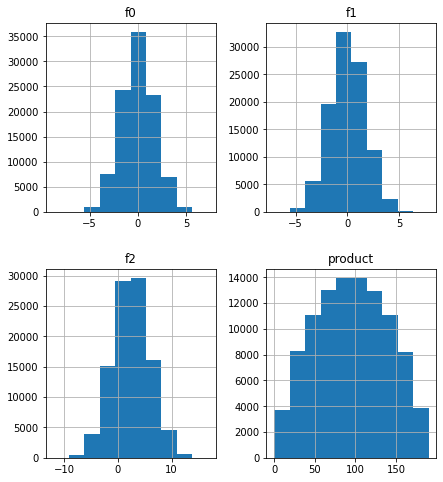

In [11]:
#Построение гистограммы для числовых значений
geo_data_2.hist(figsize=(7,8))
plt.show()

**Датасет `geo_data_2`**  медианный объем запасов составляет около 95 тыс. барраллей

# Вывод: 

Из представленных данных видно, что мы имеем 100 тысяч различных данных геологической разведки по трем областям. Эти данные включают характеристики, описывающие отдельные скважины в уже исследованных областях, и ключевые показатели объема запасов нефти в каждой из них.

**Регион 1 - `geo_data_0`**  медианный объем запасов составляет около 92 тыс. барраллей

**Регион 2 - `geo_data_1`**  медианный объем запасов составляет около 57 тыс. барраллей

**Регион 3 - `geo_data_2`**  медианный объем запасов составляет около 95 тыс. барраллей




# Предобработка данных

**Проверим данные на наличие явных дубликатов:**

In [12]:
# Проверка на наличие явных дубликатов
display(geo_data_0.duplicated().sum(), geo_data_1.duplicated().sum(), geo_data_2.duplicated().sum())

0

0

0

**Вывод:** Явные дуликаты отсутствуют.

In [13]:
# Проверка на наличие дубликатов в столбце id 
display(geo_data_0.duplicated('id').sum(), geo_data_1.duplicated('id').sum(), geo_data_2.duplicated('id').sum())

10

4

4

Проверка дубликатов в столбце `id` показала, что присутствуют дубликаты скважин, однако:

* их количество крайне мало;
* все остальные характеристики скважин отличаются.

В связи с этим мы оставим дубликаты скважин без изменений.

**Проверка наличия пропущенных значений:**

In [14]:
#Вывод пропущенных значений
display(geo_data_0.isna().sum(),geo_data_1.isna().sum(),geo_data_2.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**Вывод:** Пропущенные значения отсутствуют.

# Вывод:
Данные имеют незначительное число дубликатов в колонке `id`, пропущенные значения отсутствуют.
В целом данные достаточно чистые, можно приступить к обучению моделей.

# Обучение и проверка моделей

Разделим данные на предсказательные и целевой признак по каждому региону

In [15]:
features_0 = geo_data_0.drop(['id', 'product'], axis=1)
target_0 = geo_data_0['product']

features_1 = geo_data_1.drop(['id', 'product'], axis=1)
target_1 = geo_data_1['product']

features_2 = geo_data_2.drop(['id', 'product'], axis=1)
target_2 = geo_data_2['product']

display(features_0.shape, target_0.shape,
        features_1.shape, target_1.shape,
        features_2.shape, target_2.shape)

(100000, 3)

(100000,)

(100000, 3)

(100000,)

(100000, 3)

(100000,)

In [16]:
state = np.random.RandomState(12345)

# Разбивка данных на обучающую и валидационную выборки, аргумент test_size не указываем, т.к. он по умолчанию = 0.25.

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
                                                                        features_0, 
                                                                        target_0, 
                                                                        random_state=state)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
                                                                        features_1, 
                                                                        target_1,
                                                                        random_state=state)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
                                                                        features_2, 
                                                                        target_2,
                                                                        random_state=state)

display(features_train_0.shape, target_train_0.shape,
        features_valid_0.shape, target_valid_0.shape)
display(features_train_1.shape, target_train_1.shape,
        features_valid_1.shape, target_valid_1.shape)
display(features_train_2.shape, target_train_2.shape,
        features_valid_2.shape, target_valid_2.shape)

(75000, 3)

(75000,)

(25000, 3)

(25000,)

(75000, 3)

(75000,)

(25000, 3)

(25000,)

(75000, 3)

(75000,)

(25000, 3)

(25000,)

Для обучения выбрана модель логистической регрессии, т.к. она самая подходящая в самом случае.

In [17]:
# Модель для Региона № 1
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predictions_valid_0 = model_0.predict(features_valid_0)

result_0 = mean_squared_error(target_valid_0, predictions_valid_0) ** .5
# Расчет среднего запаса сырья по региону
average_stock_materials_0 = predictions_valid_0.mean()

display(f'RMSE: {result_0:.2f}')
display(f'Средний запас сырья по региону: {average_stock_materials_0:.2f}')

'RMSE: 37.58'

'Средний запас сырья по региону: 92.59'

In [18]:
# Модель для Региона № 2
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predictions_valid_1 = model_1.predict(features_valid_1)

result_1 = mean_squared_error(target_valid_1, predictions_valid_1) ** .5
# Расчет среднего запаса сырья по региону
average_stock_materials_1 = predictions_valid_1.mean()

display(f'RMSE: {result_1:.2f}')
display(f'Средний запас сырья по региону: {average_stock_materials_1:.2f}')

'RMSE: 0.89'

'Средний запас сырья по региону: 68.77'

In [19]:
# Модель для Региона № 3
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predictions_valid_2 = model_2.predict(features_valid_2)

result_2 = mean_squared_error(target_valid_2, predictions_valid_2) ** .5
# Расчет среднего запаса сырья по региону
average_stock_materials_2 = predictions_valid_2.mean()

display(f'RMSE: {result_2:.2f}')
display(f'Средний запас сырья по региону: {average_stock_materials_2:.2f}')

'RMSE: 39.96'

'Средний запас сырья по региону: 95.09'

# Вывод:
Модели были обучены.

Самый высокий показатель запасов сырья был обнаружен в `Регионе №3` - 95,09 тыс. тонн нефти. `Регион №1` следует за ним по показателю запасов нефти.

`Регион №2` имеет самые низкие запасы, но корень среднеквадратичного отклонения в предсказаниях для этого региона стремится к нулю, что является хорошим показателем качества предсказаний для второй модели.

# Подготовка к расчёту прибыли

Запишем ключевые значения для расчета прибыли и рисков в константы для удобства.

In [20]:
RESEARCH_POINTS = 500  # Количество скважин для анализа, шт.
BEST_POINTS = 200  # Количество выбираемых скважин, шт.
INVESTMENT = 10_000_000_000  # Инвестиции на разработку региона, млрд. руб.
BARREL_PRICE = 450 * 1000  # Доход с каждой единицы продукта, руб.
PROBABILITY_OF_LOSS = 2.5  # Вероятность убытка, %

Рассчитаем минимальный средний объем сырья для безубыточной разработки регионов.

In [21]:
# Расчет общегоо объема сырья для безубыточной разработки
min_total_materials_by_region = INVESTMENT / (BARREL_PRICE)
# Расчет среднего минимального объема сырья для безубыточной разработки
required_material_stocks = INVESTMENT / (BARREL_PRICE) / BEST_POINTS

display(f'Общий объем сырья выбранных скважин для их безубыточной разработки:',
        f'{min_total_materials_by_region:.2f} тыс. тонн баррелей')
display('Средний объем сырья в каждой скважине для их безубыточной разработки:',
        f'{required_material_stocks:.2f} тыс. тонн баррелей')

'Общий объем сырья выбранных скважин для их безубыточной разработки:'

'22222.22 тыс. тонн баррелей'

'Средний объем сырья в каждой скважине для их безубыточной разработки:'

'111.11 тыс. тонн баррелей'

**Вывод:** Из расчетов видно, что общий объем сырья выбранных скважин для их безубыточной разработки должен составлять не менее 22 222.22 тыс. тонн баррелей, а средний объем сырья в каждой скважине для их безубыточной разработки должен составлять не менее 111.11 тыс. тонн баррелей.

# Расчёт прибыли и рисков

Для начала переведем предсказанные значения к формату Series, а индексы ключевых признаков сбросим для избежания ошибок в коде.

In [22]:
# Преобразование numpy.ndarray в pd.Series
predictions_valid_0 = pd.Series(predictions_valid_0)
predictions_valid_1 = pd.Series(predictions_valid_1)
predictions_valid_2 = pd.Series(predictions_valid_2)

# Дроп индексов ключевых показателей валидационной выборки (для иcключения KeyError)
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

Напишем функции для расчета прибыли и рисков.

In [23]:
# Функция расчета прибыли
def revenue(predict_subsample, target_subsample, count=BEST_POINTS):
    predict_sorted = predict_subsample.sort_values(ascending=False)
    selected = target_subsample[predict_sorted.index][:count]
    value = (selected.sum() * BARREL_PRICE - INVESTMENT) / 1000000000
    return value


# Boostrap функция, расчет ключевых показателей
def bootstrap(predictions_valid, target):
    values = []
    for i in range(1000):
        target_subsample = target.sample(
            n=RESEARCH_POINTS, replace=True, random_state=state)
        predict_subsample = predictions_valid[target_subsample.index]
        # Передача значений ф-ции revenue
        values.append(revenue(predict_subsample, target_subsample))
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    values_mean = values.mean()
    values_loss = [num for num in values if num < 0]  # Список убытков
    # Доля убытков в общем объеме значений прибыли
    risk = len(values_loss) / len(values)
    return lower, upper, values_mean, risk


calculation_0 = bootstrap(predictions_valid_0, target_valid_0)
calculation_1 = bootstrap(predictions_valid_1, target_valid_1)
calculation_2 = bootstrap(predictions_valid_2, target_valid_2)

calculation_list = [calculation_0, calculation_1, calculation_2]
for i in range(len(calculation_list)):
    display(f'Регион {i}:')
    display(f'\t Средняя прибыль: {calculation_list[i][2]:.2f} млрд. руб.')
    display(f'\t Доверительный интервал: {calculation_list[i][0]:.2f}',
            f'- {calculation_list[i][1]:.2f} млрд. руб.')
    display(f'\t Риск убытков: {calculation_list[i][3]:.2%} \n')

'Регион 0:'

'\t Средняя прибыль: 0.42 млрд. руб.'

'\t Доверительный интервал: -0.08'

'- 0.96 млрд. руб.'

'\t Риск убытков: 4.80% \n'

'Регион 1:'

'\t Средняя прибыль: 0.51 млрд. руб.'

'\t Доверительный интервал: 0.11'

'- 0.93 млрд. руб.'

'\t Риск убытков: 0.60% \n'

'Регион 2:'

'\t Средняя прибыль: 0.38 млрд. руб.'

'\t Доверительный интервал: -0.14'

'- 0.89 млрд. руб.'

'\t Риск убытков: 7.40% \n'

# Вывод:
Из расчитанной прибыли и рисков можно сделать следующие выводы:

`Регион № 1:`
     
    Средняя прибыль по региону составляет 420 млн. руб., диапазон вириации прибыли составляет от убытка в 80 млн. руб. до прибыли в 960 млн. руб. Риск получить убыток составляет 4.80%.
     
`Регион № 2:`
     
    Средняя прибыль по региону составляет 510 млн. руб., диапазон вириации прибыли составляет от прибыли в 110 млн. руб. до прибыли в 930 млн. руб. Риск получить убыток составляет 0.60%.
     
`Регион № 3:`
     
    Средняя прибыль по региону составляет 380 млн. руб., диапазон вириации прибыли составляет от убытка в 140 млн. руб. до прибыли в 890 млн. руб. Риск получить убыток составляет 7.40%.

# Общий вывод:

Входе исследовательского проекта для Нефтедобывающей компании «ГлавРосГосНефть» были получены три датасета с данными геологоразведки трёх регионов:

- Из представленных данных определили, что мы имеем 100 тысяч различных данных геологической разведки по трем областям. Эти данные включают характеристики, описывающие отдельные скважины в уже исследованных областях, и ключевые показатели объема запасов нефти в каждой из них.

- Проводя этап предобработки данных мы убедились, что данные не имеют пропусков и в целом достаточно чисты для обучения моделей машинного обучения.

- Нами был проведен анализ нескольких нефтедобывающих регионов и изучены возможности разработки нефтяных месторождений в каждом из них. 

В результате анализа выяснилось, что:самым перспективным является `Регион №2`, который демонстрирует среднюю прибыль на уровне `510 миллионов рублей`, а безубыточный доверительный интервал составляет от `110 до 930 миллионов рублей`. Вероятность получения убытка в этом регионе сравнительно невелика – всего `0,60%`, что намного меньше, чем инвестиционная оценка риска в `2,5%`.

Другие регионы имеют более высокую вероятность получения убытков. Учитывая результаты анализа, для разработки нефтяных месторождений рекомендуется выбрать `Регион №2.`    
